In [26]:
# 실행 결과
# - Pix2Pix 모델 다운로드
# - GAN 학습을 위한 기본적인 환경 구축
import urllib.request
import zipfile
import os
import sys

repo_url = "https://github.com/tensorflow/examples/archive/refs/heads/master.zip"
urllib.request.urlretrieve(repo_url, "tensorflow_examples.zip")

with zipfile.ZipFile("tensorflow_examples.zip", "r") as zip_ref:
    zip_ref.extractall(".")

if os.path.exists("examples"):
    os.system("rm -rf examples")
os.rename("examples-master", "examples")

sys.path.append("./examples")

from tensorflow_examples.models.pix2pix import pix2pix  # jupyter notebook에서는 나올 수밖에 없음

print(dir(pix2pix))


['AUTOTUNE', 'FLAGS', 'IMG_HEIGHT', 'IMG_WIDTH', 'InstanceNormalization', 'Pix2pix', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'absolute_import', 'app', 'create_dataset', 'discriminator', 'division', 'downsample', 'flags', 'get_checkpoint_prefix', 'load', 'load_image_test', 'load_image_train', 'main', 'normalize', 'os', 'print_function', 'random_crop', 'random_jitter', 'resize', 'run_main', 'tf', 'time', 'unet_generator', 'upsample']


In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix  # jupyter notebook에서는 나올 수밖에 없음
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


In [28]:
# 실행 결과
# - 데이터셋 불려오기
# - Horse 훈련, 테스트 데이터와 zebra 훈련, 테스트 데이터 분리
# - Batch, buffer size 및 이미지 크기 설정

dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [29]:
# 실행 결과
# - 딥러닝 모델 학습 . 안정성 향상을 위한 이미지 데이터 정규화
def normalize(image):
  image = tf.cast(image, tf.float32) # tf: 실수형 숫자로 바꿔주는거
  image = (image / 127.5) - 1
  return image

In [30]:
# 실행 결과
# - GAN 모델에서 이미지 데이터 증강 정의
        # >> 사진이 많아지면 더 똑똑해지지만, 적으면 데이터를 더 많이 보이게 해야하기 때문
# - Resizing, 좌우 반전 및 random cropping
def random_crop(image):
    return tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

def random_jitter(image):
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = random_crop(image)

    image = tf.image.random_flip_left_right(image)
    return image



In [31]:
# 실행 결과
# - 이미지 데이터를 학습에 적합한 형태로 전처리하는 역할
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image


In [32]:
# 실행 결과
# - test 데이터에 대해 전처리를 수행하는 역할
def preprocess_image_test(image, label):
  image = normalize(image)
  return image


In [33]:
# 학습용 데이터 (정상 순서)
train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
train_horses = train_horses.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
train_zebras = train_zebras.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 테스트용 데이터 (shuffle 제거, cache는 optional)
test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
test_horses = test_horses.cache().batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
test_zebras = test_zebras.cache().batch(BATCH_SIZE)

In [34]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))



2025-07-26 16:30:35.082944: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-26 16:30:36.323233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-26 16:30:36.330777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `datas

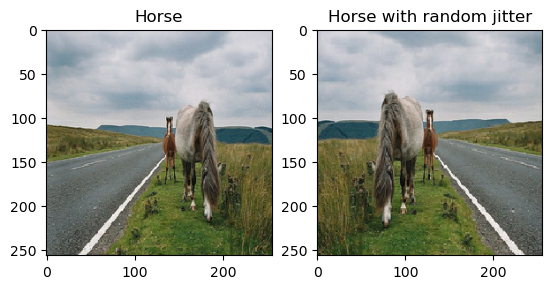

In [42]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)


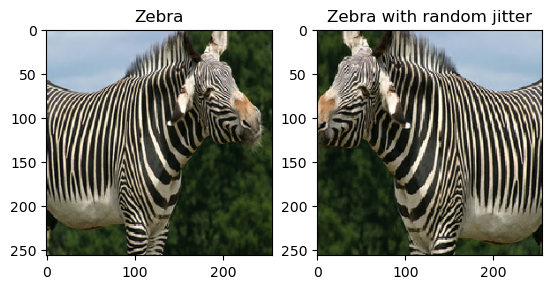

In [45]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [47]:
# 실행 결과:
# - GAN 모델의 Generator Discriminator 설정
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [48]:
# 실행 결과
# - GAN 학습을 위한 손실 함수 설정
# - GAN의 Discriminator 손실 계산
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [50]:
# GAN의 Generator 손실 계산
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

# GAN의 Cycle Consistency Loss 계산
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

# GAN Identity Loss 계산
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


In [51]:
# Generator와 Discriminator 학습을 위한 Optimizer 설정
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [52]:
# GAN 학습 과정에서 Checkpoint를 저장 및 관리
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [53]:
# GAN 학습을 위한 Checkpoint 복원 및 학습 설정 (학습 횟수 설정)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
EPOCHS = 50


In [56]:
# GAN 모델 생성한 이미지 시각화
# 변환한 이미지와 원본 이미지를 비교하여 시각적으로 확인
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()


In [60]:
# GAN의 한 학습 step 수행
# Generator와 Discriminator의 학습을 위한 입력 준비
# GAN의 Generator, Discriminator loss, Gradient 계산
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # Generator Loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    # Cycle Loss
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # 전체 Generator Loss
    # Generator G (말 → 얼룩말) 방향의 전체 손실 계산
    # 1. Generator가 만든 얼룩말 이미지가 진짜처럼 보이도록 속였는가? → gen_g_loss
    # 2. 말 → 얼룩말 → 다시 말로 되돌렸을 때 원래 말 이미지와 얼마나 비슷한가? → total_cycle_loss
    # 3. 얼룩말을 얼룩말로 변환했을 때 원본과 같은가? → identity_loss
    # 세 가지 손실을 모두 더해서 Generator G의 학습 기준을 정합니다.

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)


    # Generator F (얼룩말 → 말) 방향의 전체 손실 계산
    # 1. Generator가 만든 말 이미지가 진짜처럼 보이도록 속였는가? → gen_f_loss
    # 2. 얼룩말 → 말 → 다시 얼룩말로 되돌렸을 때 원래 얼룩말과 얼마나 비슷한가? → total_cycle_loss
    # 3. 말 이미지를 그대로 말로 변환했을 때, 원본과 같은가? → identity_loss
    # 세 가지 손실을 모두 더해서 Generator F의 학습 기준을 정합니다.

    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)


    # Discriminator Loss
    # Discriminator 손실 계산 (말 방향)
    # disc_real_x: 진짜 말 이미지에 대한 Discriminator의 출력
    # disc_fake_x: 가짜 말 이미지 (Generator가 만든 것)에 대한 Discriminator의 출력
    # 이 두 값을 가지고 Discriminator가 잘 구별했는지를 평가합니다.
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)

    # Discriminator 손실 계산 (얼룩말 방향)
    # disc_real_y: 진짜 얼룩말
    # disc_fake_y: Generator가 만든 가짜 얼룩말
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Gradient 계산
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) # 이게 얼마나 틀렸는지를 기준으로 Generator의 파라미터를 어떻게 바꿀지 정합니다
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) # Generator F의 손실 기반 Gradient
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) # Discriminator X의 손실(disc_x_loss)에 대한 Gradient
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) # Discriminator Y의 손실에 대한 Gradient

    # Optimizer로 업데이트 -> 추가된 부분
    # 앞서 계산한 Gradient를 가지고 실제로 '가중치'를 수정하여 학습이 일어나게 합니다.
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables)) # Generator G 업데이트
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables)) # Generator F 업데이트
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables)) # Discriminator X 업데이트
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables)) # Discriminator Y 업데이트

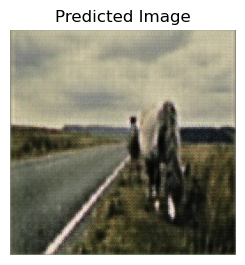


Epoch 16 completed in 18.75 sec


2025-07-26 17:14:23.204558: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-26 17:14:23.206022: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-26 17:14:23.218777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. I

In [ ]:
MAX_BATCHES = 1

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)).take(MAX_BATCHES):
        train_step(image_x, image_y)

        if n % 100 == 0:
            print('.', end='')
        n += 1


        # GAN 학습 과정에서 주기적으로 체크포인트 저장
        # 학습에 걸린 시간을 출력
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))

    clear_output(wait=True)
    generate_images(generator_g, sample_horse)
    print(f"\nEpoch {epoch+1} completed in {time.time()-start:.2f} sec")


In [ ]:
for inp in test_horses.take(5):
    generate_images(generator_g, inp)

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
#contrast = 8
imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])

    if i % 2 == 0:
        plt.imshow((imgs[i][0] + 1) / 2)
    else:
        plt.imshow((imgs[i][0] + 1) / 2)
        plt.show()

In [ ]:
# GAN의 Discriminator 시각화
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()
